In [1]:

import numpy as np 
import torch
import matplotlib.pyplot as plt
from typing import List
from ddpgportfolio.agent import DDPGAgent, BuyHoldAgent
from ddpgportfolio.portfolio.portfolio import Portfolio

In [2]:
# The purpose of this file is to create a price tensor for input into the neural network
# and to train the policy using Deep Deterministic Policy Gradient.
# Code is inspired by the paper "A Deep Reinforcement Learning Framework for the Financial Portfolio Management Problem"
# For more details, see: c.f https://arxiv.org/abs/1706.10059





torch.set_default_device("mps")


INITIAL_CASH = 10000
BATCH_SIZE = 128  # training is done in mini-batches
WINDOW_SIZE = 100  # last n timesteps for the price tensor
STEP_SIZE = 1  # for rolling window batch sampler
train_start_date = "2024-01-01"  # start date of trading
train_end_date = "2024-07-30"
test_start_date = "2024-08-01"
test_end_date = "2024-09-30"
N_EPISODES = 6  # number of episodes to train the agent
DEVICE = "mps"

asset_names: List[str] = ["CASH", "SOL", "PEPE", "ETH", "TRX", "MATIC", "LINK"]


train_port = Portfolio(asset_names=asset_names, start_date=train_start_date, end_date=train_end_date, initial_cash=INITIAL_CASH)
test_port = Portfolio(asset_names=asset_names, start_date=test_start_date, end_date=test_end_date, initial_cash=INITIAL_CASH)

ddpg_agent = DDPGAgent(train_port, BATCH_SIZE, WINDOW_SIZE, STEP_SIZE, device=DEVICE)
bh_agent = BuyHoldAgent(test_port, BATCH_SIZE, WINDOW_SIZE, STEP_SIZE, cash_weight=0.2, device=DEVICE)



In [3]:
bh_equity_curve = bh_agent.build_equity_curve()

### Equity Curve for Buy and Hold Agent
- Below is the Equity Curve for a Buy and Hold Agent who has 20% allocated to cash and the other 80% allocated to non cash coins.  The Equity curve uses the out of sample test set from 2024-08-01 till 2024-09-31

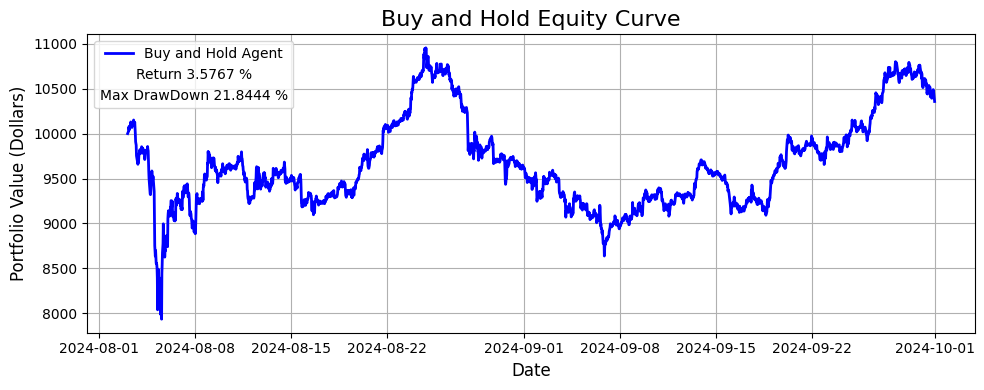

In [4]:
import matplotlib.offsetbox as offsetbox
cl_price = test_port.get_close_price()
dates = cl_price.index
bh_return = bh_agent.portfolio.calculate_final_equity_return(bh_equity_curve)
bh_mdd = bh_agent.portfolio.calculate_max_drawdown(bh_equity_curve)


plt.figure(figsize=(10, 4))
plt.grid()
plt.plot(dates[WINDOW_SIZE:], bh_equity_curve, label="Buy and Hold Agent", linewidth=2, color='blue');
plt.title("Buy and Hold Equity Curve", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Portfolio Value (Dollars)", fontsize=12)

#plt.legend(loc='best');
a = plt.legend(loc='best')

txt1=offsetbox.TextArea(f"Return {bh_return:.4f} %")
txt2=offsetbox.TextArea(f"Max DrawDown {bh_mdd:.4f} %")
box = a._legend_box
box.get_children().append(txt1)
box.get_children().append(txt2)

box.set_figure(box.figure)
plt.tight_layout()



In [ ]:
# train agent
ddpg_agent.train(6);

Training Started for DDPG Agent


## Equity Curve for DDPG Agent


In [6]:
ddpg_equity_curve = ddpg_agent.build_equity_curve(test_port)

In [10]:
ddpg_equity_curve[1:] = [equity.item() for equity in ddpg_equity_curve[1:]]

In [11]:
ddpg_equity_curve[1]

9982.8857421875

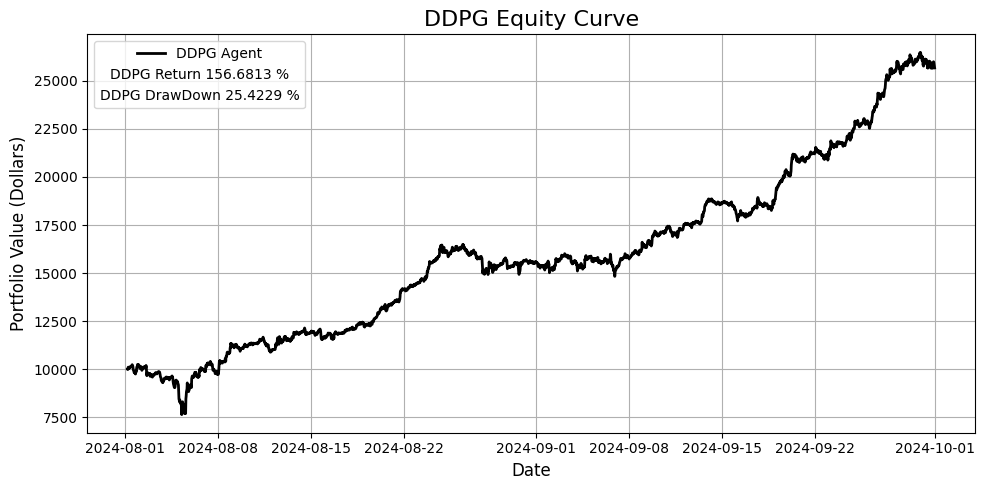

In [20]:
import matplotlib.offsetbox as offsetbox
cl_price = test_port.get_close_price()
dates = cl_price.index
ddpg_return = ddpg_agent.portfolio.calculate_final_equity_return(ddpg_equity_curve)
ddpg_mdd = ddpg_agent.portfolio.calculate_max_drawdown(ddpg_equity_curve)


plt.figure(figsize=(10, 5))
plt.plot(dates[10:], ddpg_equity_curve, label="DDPG Agent", linewidth=2, color='black');
#plt.plot(dates[10:], np.log(bh_equity_curve), label="Buy and Hold Agent", linewidth=2, color='b');
plt.title("DDPG Equity Curve", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Portfolio Value (Dollars)", fontsize=12)

#plt.legend(loc='best');
a = plt.legend(loc='best')

txt1=offsetbox.TextArea(f"DDPG Return {ddpg_return:.4f} %")
txt2=offsetbox.TextArea(f"DDPG DrawDown {ddpg_mdd:.4f} %")
box = a._legend_box
box.get_children().append(txt1)
box.get_children().append(txt2)

box.set_figure(box.figure)
plt.tight_layout()
plt.grid()

In [21]:
import pickle
with open("ddpg_agent_run11_good_perf_six_assets.pkl", "wb") as f:
    pickle.dump(ddpg_agent, f)

In [5]:
import pickle
with open("ddpg_agent_run10_good_perf_six_assets.pkl", "rb") as f:
    ddpg_agent = pickle.load(f)


In [11]:
rewards = [exp.reward for exp in ddpg_agent.replay_memory.buffer]

Reward Min: -11.940805903900706, Reward Max: 18.53978291419076
Reward Mean: 0.011989923519419523, Reward Std: 1.0109159798998388


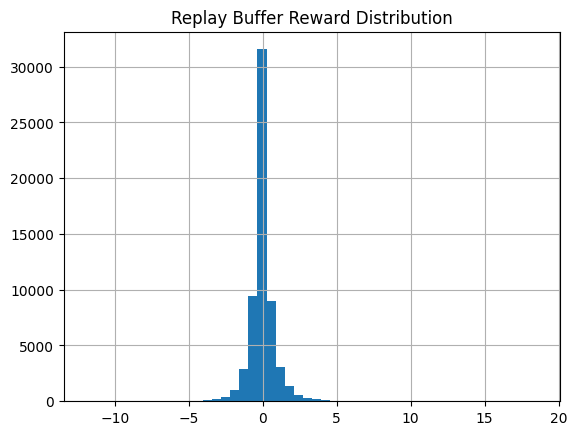

In [12]:
import matplotlib.pyplot as plt
print(f"Reward Min: {min(rewards)}, Reward Max: {max(rewards)}")
print(f"Reward Mean: {np.mean(rewards)}, Reward Std: {np.std(rewards)}")
plt.hist(rewards, bins=50)
plt.title("Replay Buffer Reward Distribution")

plt.grid()

In [ ]:
np.random.uniform(
                -3, 3
            )  # Simulate expected reward range

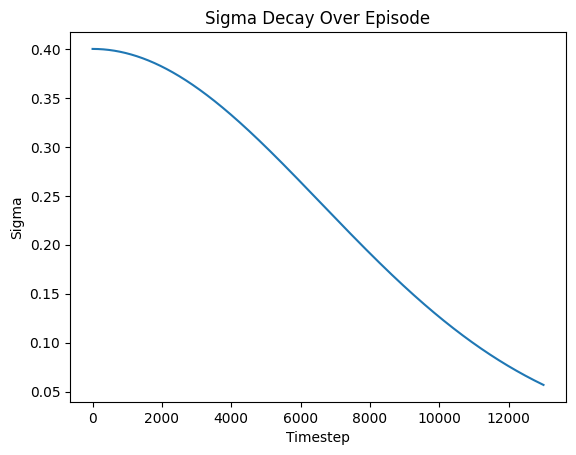

In [13]:
import matplotlib.pyplot as plt
import numpy as np

sigma_values = []
sigma = 0.4  # Initial sigma
decay_rate_within_episode = 0.0003
min_sigma = 0.05
n_samples = 13_000

for t in range(1, n_samples + 1):
    dt = t / n_samples
    sigma = max(sigma * np.exp(-dt * decay_rate_within_episode), min_sigma)
    sigma_values.append(sigma)

plt.plot(range(1, n_samples + 1), sigma_values)
plt.title("Sigma Decay Over Episode")
plt.xlabel("Timestep")
plt.ylabel("Sigma")
plt.show()


In [29]:
sigma_values[13000:]

[]